In [1]:
import pandas as pd
import numpy as np
import eikon as ek
import sys
import config
ek.set_app_key(config.eikon_key)
#import DatastreamDSWS as DSWS
#ds = DSWS.Datastream(username = 'JGarden1@lidoadvisors.com', password= 'Welcome2')
from datetime import timedelta
import datetime

from scipy.optimize import minimize
from arch import arch_model

from tqdm import tqdm
TOLERANCE = 1e-15
import warnings
warnings.filterwarnings("ignore")
import cufflinks as cf
import configparser as cp
cf.set_config_file(offline = True)


#import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)
#from scipy.optimize import OptimizeWarning
#warnings.simplefilter(action='ignore', category=OptimizeWarning)

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import chart_studio
from chart_studio.plotly import plot, iplot
import chart_studio.plotly as py
from PIL import Image as im
#import Lido_funcs3 as lf
import time
from sklearn.linear_model import LinearRegression

import IPython.display
from IPython.display import Image

import chart_studio.tools as tls

import plotly.io as pio

import plotly.figure_factory as ff

from plotly.subplots import make_subplots
import scipy.stats as st
from tqdm import tqdm
import random

from sklearn.preprocessing import RobustScaler, MinMaxScaler
from scipy.stats.mstats import winsorize
from scipy import stats
ek.set_timeout(60)

from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

In [2]:
def win_df(df):
    return df.apply(using_mstats, axis=0)

def using_mstats(s):
    return winsorize(s, limits=[0.05, 0.2])

In [3]:
###This cell sets up a list that contains dates used to call needed data from the API


mar = []
jun = []
sept = []
dec = []

for i in range(2015, 2021):
    dt_3 = datetime.date(i, 3, 15)
    if dt_3.isoweekday() == 6:
        dt_3 = datetime.date(i, 3, 17)
    elif dt_3.isoweekday() == 7:
        dt_3 = datetime.date(i, 3, 16)
    st_dt_3 = dt_3.strftime("%Y-%m-%d")
    mar.append(st_dt_3)
    dt_6 = datetime.date(i, 6, 15)
    if dt_6.isoweekday() == 6:
        dt_6 = datetime.date(i, 6, 17)
    elif dt_6.isoweekday() == 7:
        dt_6 = datetime.date(i, 6, 16)
    st_dt_6 = dt_6.strftime("%Y-%m-%d")
    jun.append(st_dt_6)
    dt_9 = datetime.date(i, 9, 15)
    if dt_9.isoweekday() == 6:
        dt_9 = datetime.date(i, 9, 17)
    elif dt_9.isoweekday() == 7:
        dt_9 = datetime.date(i, 9, 16)
    st_dt_9 = dt_9.strftime("%Y-%m-%d")
    sept.append(st_dt_9)
    dt_12 = datetime.date(i, 12, 15)
    if dt_12.isoweekday() == 6:
        dt_12 = datetime.date(i, 12, 17)
    elif dt_12.isoweekday() == 7:
        dt_12 = datetime.date(i, 12, 16)
    st_dt_12 = dt_12.strftime("%Y-%m-%d")
    dec.append(st_dt_12)
    

dates = []
for i in range(0, len(mar)):
    dates.append(mar[i])
    dates.append(jun[i])
    dates.append(sept[i])
    dates.append(dec[i])

In [4]:
def get_SP5X_stocks():
    '''This function imports the Symbols (RICS) for all stocks in the SPDR S&P 500 Deposetory recipt ETF do not run w/o a subscription to refinitive.'''
    hold = ek.get_data('SPY', fields = [ek.TR_Field('TR.ETPConstituentRIC',params={'SDate':'2021-01-07'})])[0]
    hold = hold[hold['Constituent RIC'] != 'GOOG.OQ']
    rics = [x for x in hold['Constituent RIC']]
    if 'GOOG.OQ' in rics == True:
        rics.remove('GOOG.OQ')
    return rics
    
    

In [5]:
def API_req(spx, date):
    '''This function calls all the features for each stock at a given date, do not run w/o a subscription to refinitive. '''
    valuation_fields = [ek.TR_Field('TR.GICSSector'),ek.TR_Field('TR.NetProfitMean', params={'Period':'FY2', 'SDate': date}), ek.TR_Field('TR.EBITDAReportedMean',  params={'Period':'FY2', 'SDate': date}),
                        ek.TR_Field('TR.EBITMean', params = {'Period':'FY2', 'SDate': date}), ek.TR_Field('TR.TotalEquity', params = {'Period':'FY0','SDate': date}),
                        ek.TR_Field('TR.CompanyMarketCap', params = {'SDate': date}), ek.TR_Field('TR.EV', params = {'SDate': date})]
    valuation_dat = ek.get_data(spx, fields=valuation_fields)[0]
    valuation_dat.to_csv('SPX_VALUATION_{}.csv'.format(date))
    time.sleep(10)
        
    fundam_fields = [ek.TR_Field('TR.GICSSector'), ek.TR_Field('TR.ROICMean', params={'Period':'FY2', 'SDate': date}), ek.TR_Field('TR.WACC'), ek.TR_Field('TR.ROEMean',params={'Period':'FY2', 'SDate': date}),
                 ek.TR_Field('TR.WACCCostofEquity', params={'SDate': date}), ek.TR_Field('TR.LTGMean', params={'SDate': date}), ek.TR_Field('TR.TtlDebtToTtlCapitalPct', params={'Period':'FY0', 'SDate': date})]
    fundamental_dat = ek.get_data(spx, fields=fundam_fields)[0] 
    fundamental_dat.to_csv('SPX_FUNDAM_{}.csv'.format(date))
    time.sleep(10)
    mom_fields = [ek.TR_Field('TR.GICSSector'), ek.TR_Field('TR.TotalReturn3Mo', params={'SDate': date}), ek.TR_Field('TR.TotalReturn6Mo', params={'SDate': date}), 
                  ek.TR_Field('TR.TotalReturn52Wk', params={'SDate': date}), ek.TR_Field('TR.WACCBeta',params={'SDate': date})]
    momentum = ek.get_data(spx, fields=mom_fields)[0]
    spy_rets = ek.get_data('SPY', fields=mom_fields)[0]
    momentum.to_csv('SPX_MOM_{}.csv'.format(date))
    spy_rets.to_csv('INDEX_MOM_{}.csv'.format(date))
    
    return (valuation_dat, fundamental_dat, mom_fields, spy_rets)
        
        
    

In [6]:
def import_stock_dat(dates):
    '''This function creates the dataset needed for the the rest of the project, do not run with out a Refinitive eikon subscription and takes about 30 Min '''
    spx = get_SP5X_stocks()
    for date in dates:
        API_req(spx, date)
        time.sleep(5)
    return spx
    

In [7]:
#spx = import_stock_dat(['2020-03-16'])

In [8]:
def valuation_dat(date):
    valuation_dat = pd.read_csv('SPX_VALUATION_{}.csv'.format(date))
    valuation_dat['Earnings_Yield'] = valuation_dat['Net Income - Mean']/valuation_dat['Company Market Cap']
    valuation_dat['Book_Market'] = valuation_dat['Total Equity']/valuation_dat['Company Market Cap']
    valuation_dat['EBITDA_EV'] = valuation_dat['EBITDA Reported - Mean']/valuation_dat['Enterprise Value (Daily Time Series)']
    valuation_dat['EBIT_EV'] = valuation_dat['EBIT - Mean']/valuation_dat['Enterprise Value (Daily Time Series)']
    
    sectors = list(valuation_dat['GICS Sector Name'].drop_duplicates())
    
    valuation = pd.DataFrame()
    for s in sectors:
        x =  valuation_dat[valuation_dat['GICS Sector Name']==s]
        meds = x.median()
        x = x.fillna(meds)
        valuation = pd.concat([valuation, x])
    
    
    valuation[['Earnings_Yield', 'Book_Market', 'EBITDA_EV', 'EBIT_EV']] = win_df(valuation[['Earnings_Yield', 'Book_Market', 'EBITDA_EV', 'EBIT_EV']])
    
    valuation_dat_mkt = valuation
    valuation_dat_mkt = valuation_dat.filter(['Instrument', 'GICS Sector Name', 'Earnings_Yield', 'Book_Market', 'EBITDA_EV', 'EBIT_EV'])
    min_max = MinMaxScaler()
    valuation_dat_mkt[['Earnings_Yield', 'Book_Market', 'EBITDA_EV', 'EBIT_EV']] = min_max.fit_transform(valuation_dat_mkt[['Earnings_Yield', 'Book_Market', 'EBITDA_EV', 'EBIT_EV']])
    valuation_dat_mkt['Valuation Composite'] = valuation_dat_mkt.mean(axis = 1)
    valuation_dat_mkt[['Valuation Composite']] = min_max.fit_transform(valuation_dat_mkt[['Valuation Composite']])
    val_comp = valuation_dat_mkt['Valuation Composite']
    valuation_dat_mkt = valuation_dat_mkt.drop('Valuation Composite', axis = 1)
    
    return valuation_dat_mkt, val_comp
    
    

In [9]:
def fundamental_dat(date):
    fundamental_dat = pd.read_csv('SPX_FUNDAM_{}.csv'.format(date))
    fundamental_1 = fundamental_dat[fundamental_dat['Return On Invested Capital - Mean'].isnull()]
    fundamental_1['Spread'] = fundamental_1['Return On Equity - Mean'] - fundamental_1['WACC Cost of Equity, (%)']
    fundamental_2 = fundamental_dat[fundamental_dat['Return On Invested Capital - Mean'].notnull()]
    fundamental_2['Spread'] = fundamental_2['Return On Invested Capital - Mean'] - fundamental_2['Weighted Average Cost of Capital, (%)']
    fundamental_score = pd.concat([fundamental_2, fundamental_1])
    fundamental_score['Equity To Total Cap'] = 100 - fundamental_score['Total Debt to Total Capital, Percent']
    
    sectors = list(fundamental_score['GICS Sector Name'].drop_duplicates())
    
    fund_df= pd.DataFrame()
    for s in sectors:
        x =  fundamental_score[fundamental_score['GICS Sector Name']==s]
        meds = x.median()
        x = x.fillna(meds)
        fund_df= pd.concat([fund_df, x])
    
    fund_df[['Return On Invested Capital - Mean', 'Weighted Average Cost of Capital, (%)', 'Return On Equity - Mean', 
                       'WACC Cost of Equity, (%)', 'Long Term Growth - Mean', 'Total Debt to Total Capital, Percent', 'Spread', 
                       'Equity To Total Cap']] = win_df(fund_df[['Return On Invested Capital - Mean', 'Weighted Average Cost of Capital, (%)', 'Return On Equity - Mean', 
                       'WACC Cost of Equity, (%)', 'Long Term Growth - Mean', 'Total Debt to Total Capital, Percent', 'Spread', 
                       'Equity To Total Cap']])
    
    min_max = MinMaxScaler()
    fund_df[['Return On Invested Capital - Mean', 'Weighted Average Cost of Capital, (%)', 'Return On Equity - Mean', 
                       'WACC Cost of Equity, (%)', 'Long Term Growth - Mean', 'Total Debt to Total Capital, Percent', 'Spread', 
                       'Equity To Total Cap']] = min_max.fit_transform(fund_df[['Return On Invested Capital - Mean', 'Weighted Average Cost of Capital, (%)', 'Return On Equity - Mean', 
                       'WACC Cost of Equity, (%)', 'Long Term Growth - Mean', 'Total Debt to Total Capital, Percent', 'Spread', 
                       'Equity To Total Cap']])

        
    
    fund_df['FUND_Composite'] = fund_df[['Spread', 'Long Term Growth - Mean', 'Equity To Total Cap']].sum(axis = 1)
    min_max = MinMaxScaler()
    fund_df[['FUND_Composite']]  = min_max.fit_transform(fund_df[['FUND_Composite']])
    fund_comp = fund_df[['FUND_Composite']] 
    fundamental_score = fund_df.drop('FUND_Composite', axis = 1)
    
    return fundamental_score, fund_comp
    

In [10]:
def momentum_dat(date):
    
    momentum = pd.read_csv('SPX_MOM_{}.csv'.format(date))
    spy_rets = pd.read_csv('INDEX_MOM_{}.csv'.format(date))
    mom_1 = momentum[momentum['Beta'].notnull()]
    mom_2 = momentum[momentum['Beta'].isnull()]
    mom_1['3_month'] = mom_1['3 Month Total Return'] - (spy_rets['3 Month Total Return'].iloc[0] * mom_1['Beta'])
    mom_1['6_month'] = mom_1['6 Month Total Return'] - (spy_rets['6 Month Total Return'].iloc[0] * mom_1['Beta'])
    mom_1['12_month'] = mom_1['52 Week Total Return'] - (spy_rets['52 Week Total Return'].iloc[0] * mom_1['Beta'])
    mom_2['3_month'] = mom_2['3 Month Total Return'] - spy_rets['3 Month Total Return'].iloc[0]
    mom_2['6_month'] = mom_2['6 Month Total Return'] - spy_rets['6 Month Total Return'].iloc[0]
    mom_2['12_month'] = mom_2['52 Week Total Return'] - spy_rets['52 Week Total Return'].iloc[0]    
    momentum = pd.concat([mom_1, mom_2])
    momentum = momentum.filter(['Instrument', 'GICS Sector Name', '3_month', '6_month', '12_month'])
    
    sectors = list(momentum['GICS Sector Name'].drop_duplicates())
    
    mom_df= pd.DataFrame()
    for s in sectors:
        x =  momentum[momentum['GICS Sector Name']==s]
        meds = x.median()
        x = x.fillna(meds)
        mom_df= pd.concat([mom_df, x])
        
    mom_df[['3_month', '6_month', '12_month']] = win_df(mom_df[['3_month', '6_month', '12_month']])
    
    momentum = mom_df
    min_max = MinMaxScaler()  
    momentum[['3_month', '6_month', '12_month']] = min_max.fit_transform(momentum[['3_month', '6_month', '12_month']])
    momentum['MOM_Composite'] = momentum.sum(axis = 1)
    min_max = MinMaxScaler()    
    momentum[['MOM_Composite']]= min_max.fit_transform(momentum[['MOM_Composite']])
    mom_comp = momentum['MOM_Composite']
    momentum = momentum.drop('MOM_Composite', axis = 1)
    
    return momentum, mom_comp
    
    

In [11]:
def feature_prep(date):
    val, val_comp = valuation_dat(date)
    fund, fund_comp = fundamental_dat(date)
    mom, mom_comp = momentum_dat(date)
    val = val.set_index('Instrument')
    fund = fund.set_index('Instrument')
    mom = mom.set_index('Instrument')
    
    fund = fund.filter(['Return On Invested Capital - Mean', 'Long Term Growth - Mean','Spread',])
    mom = mom.filter(['3_month', '6_month', '12_month'])
    val = val.join(fund, on  = 'Instrument')
    val = val.join(mom, on  = 'Instrument')
    sectors = list(val['GICS Sector Name'].drop_duplicates())
    
    features = pd.DataFrame()
    for s in sectors:
        x = val[val['GICS Sector Name']==s]
        meds = x.median()
        x = x.fillna(meds)
        features = pd.concat([features, x])
        
    features = features.fillna(0)
    features = features.drop('GICS Sector Name', axis = 1)


    
    #comps = val_comp.to_frame(name = 'Value')
    #comps = comps.join(mom_comp)
    #comps = comps.join(fund_comp)
    #comps['Instrument'] = list(features.index)
    
    return features
    

In [12]:

def Kmeans(date):
    X= feature_prep(date)
    clstr = KMeans(n_clusters = 4)
    clstr_labs = clstr.fit(X)
    labs =  clstr.labels_

    
    X['Clusters'] = labs
    
    return X
        
        
        

In [13]:
def run_KMtest(dates):
    results = dict()
    for d in dates:
        results[d] = Kmeans(d)
    return results

In [14]:
dates = dates[3:]



In [15]:
mod_dict = run_KMtest(dates)

In [225]:
def port_const(mod_dict):
    
    dates = list(mod_dict.keys())
    chain = []
    mth = []
    sval = 1000000
    
    for i in range(0,len(dates)):
        #try:
            #universe = mod_dict[dates[i]]
            #eval_df = universe.groupby('Clusters').mean()
            #eval_df['AVG_SCORE'] = eval_df.mean(axis = 1)
            #selection = eval_df['AVG_SCORE'].idxmax()
            #port = universe[universe['Clusters'] == selection]
            #rics = list(port.index)
            #px_df = ek.get_timeseries(rics, fields = 'CLOSE', start_date = dates[i], end_date = dates[i+1], interval = 'monthly')
            #px_df.to_csv('{}_KMEANS_PORT.csv'.format(dates[i]))
        px_df = pd.read_csv('{}_KMEANS_PORT.csv'.format(dates[i]), index_col = 'Date')
        px_df = px_df.dropna(axis = 1)
        px_pershare = list(px_df.iloc[0])
        weights = [1/len(px_pershare) for i in px_pershare]
        allocs = [i * sval for i in weights]
        shares = [i/j for i, j in zip(allocs, px_pershare)]
        for d in px_df.index:
            v = np.dot(shares, px_df.loc[d])
            mth.append(d)
            chain.append(v)
            sval = v
            
    returns = pd.DataFrame({'Date':mth, 'Port': chain})
    
    rsp = pd.read_csv('RSP_DAT.csv', index_col ='Date')
    bm_dat = list(rsp['CLOSE'])
    returns['BM'] = bm_dat
    returns['BM'] = returns['BM']/returns['BM'].iloc[0]
    returns['Port'] = returns['Port']/returns['Port'].iloc[0]



    
    return returns

In [226]:
port_df = port_const(mod_dict)

In [227]:
port_df

,Date,Port,BM
0,2015-12-31,1.000000,1.000000
1,2016-01-31,0.950248,0.944415
2,2016-02-29,0.959577,0.953810
3,2016-03-31,0.959577,1.024661
4,2016-04-30,0.950733,1.037448
...,...,...,...
57,2020-09-30,2.046183,1.410621
58,2020-10-31,2.001202,1.402792
59,2020-11-30,2.209223,1.603340
60,2020-12-31,2.209223,1.664144


In [230]:
def perf_plot(port_df):
    funds = port_df
    portfolios = funds.filter(['Date', 'Port', 'BM'])
    fig_perf = go.Figure()

    fig_perf.add_trace(
        go.Scatter(
        x = portfolios['Date'],
        y = portfolios['Port'],
        name = 'KMeans Stock Selection',
        line = {'color': '#00274C'}))



    fig_perf.add_trace(
        go.Scatter(
        x = portfolios['Date'],
        y = portfolios['BM'],
        name = 'Equal Weight S&P 500',
        line = {'color': '#FFCB05'}))



    fig_perf.update_yaxes(tickformat=".2%", title = 'Portfolio Return')




    fig_perf.update_layout(legend=dict(orientation='h',yanchor='top',xanchor='center',y=-0.05, x=0.5), paper_bgcolor='white',
        plot_bgcolor='white' , height = 800, width = 1200, title_text='Performance', title_x=0.5)
    
    daily_rp = portfolios['Port'].pct_change().dropna()
    daily_6040 = portfolios['BM'].pct_change().dropna()

    
    mu_a = daily_rp.mean() *252
    mu_b = daily_6040.mean() * 252

    
    sig_a = daily_rp.std() * (252**0.5)
    sig_b = daily_6040.std() * (252**0.5)


    active_sharpe = (mu_a)/sig_a
    bh_sharpe = (mu_b)/sig_b

    
    
    
    print('RPAR Portfolio Sharpe: {:.2f}'.format(active_sharpe))
    print('Bond Sharpe: {:.2f}'.format(bh_sharpe))
    print(sig_a, sig_b)

    return fig_perf.show()


RPAR Portfolio Sharpe: 5.88
Bond Sharpe: 2.99
MSCI All Countery Index: 2.99
0.5767444072452922 0.8049251351962373


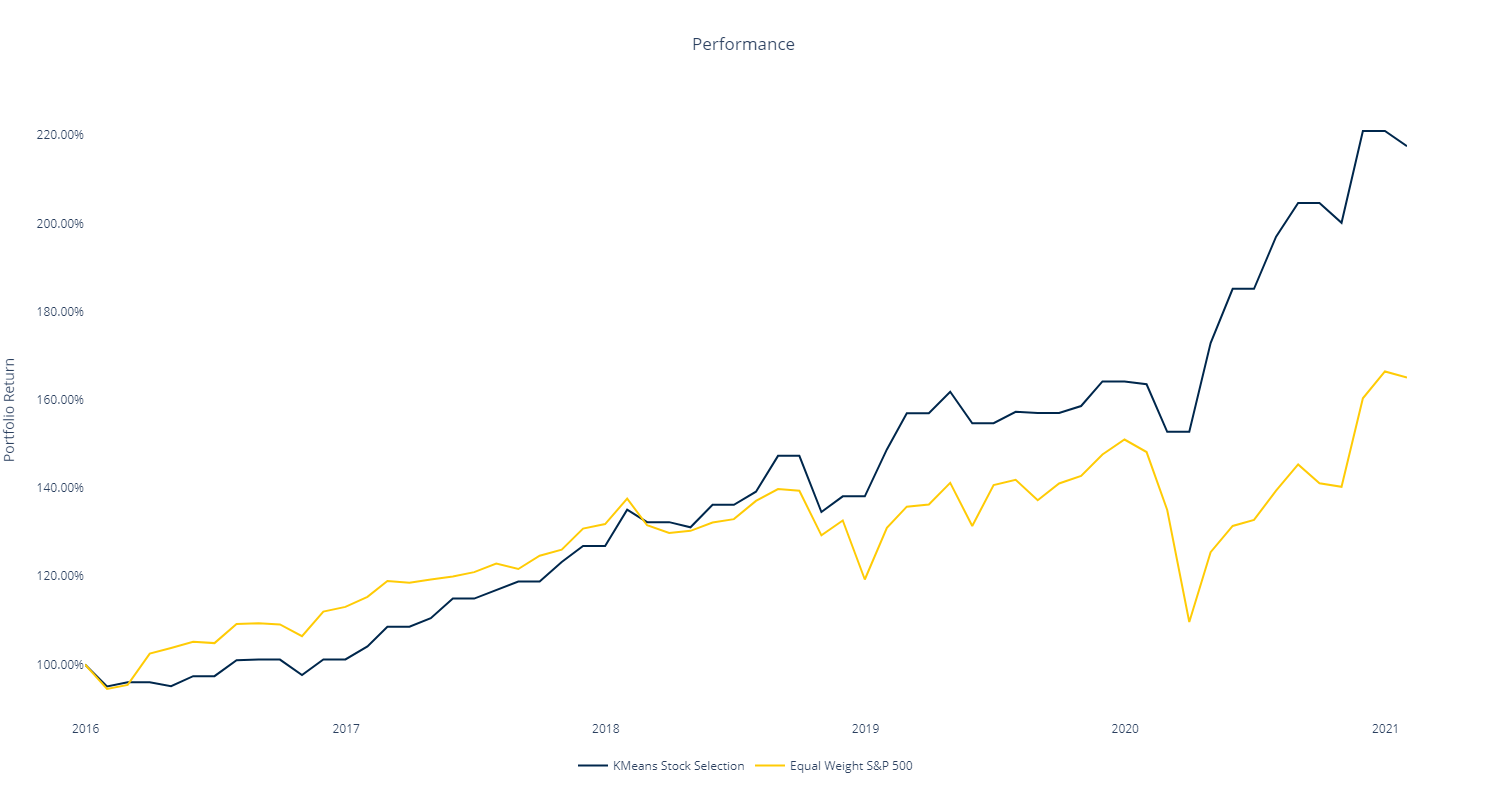

In [231]:
perf_plot(port_df)

In [232]:
fig_2 = px.scatter_3d(mod_dict[dates[11]], x = '12_month', y ='EBIT_EV', z = 'Spread', color = 'Clusters', hover_name=mod_dict[dates[11]].index, opacity = 0.8)
fig_2.update_layout(
        paper_bgcolor='white',
        plot_bgcolor= 'white',
        height = 950,
        width = 740,
        font = dict(family= 'pt sans narrow'),
        title= {'text': "Kmeans Clusters", 'font':{'size':25}})
    
fig_2.update_traces(marker_coloraxis=None, marker=dict(size=4,
                              line=dict(width=1)))
    
    
pio.write_html(fig_2, file='clust.html', auto_open=True)

In [174]:
t = mod_dict['2015-12-15']